- Una sección llamada __Preliminares__ donde se realiza la descripción del problema y objetivos, así como explicar cómo implementarán su solución. Debe considerar qué criterios de optimización y métricas de desempeño.
- Una sección llamada __Aspectos computacionales__ donde se describirán las librerías y módulos a implementar, así como las funciones generadas y su objetivo.

# __Aspectos computacionales__

Seran añadidos a medida que sean requeridos los diversos import de librerias, no se generaran librerias externas, serin explicitas dentro de este notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import os
import preproc_nyc_sqf as preproc
import helpers
import pickle

warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (15,12)
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('2009_1perc.csv').drop(columns='Unnamed: 0')

In [3]:
df.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2009,41,1779,4032009,130,A,O,P,1.0,CPW,...,,41,G,7,,1013067,0238633,CM,1,20
1,2009,108,5805,10292009,1050,A,O,P,3.0,BURG,...,,108,J,,,1012043,0212157,CM,1,14
2,2009,43,8340,10062009,1450,1,O,P,1.0,MISD,...,,43,E,,,1017599,0240200,CM,1,20
3,2009,77,932,1232009,1843,A,O,P,5.0,MIS,...,,77,J,4,35,1002625,0183442,CM,1,24
4,2009,110,11224,12132009,1655,A,O,P,3.0,CPW,...,,110,H,,,1024535,0209890,CM,1,20


In [4]:
proc_df, suitable_categorical_attributes, suitable_numerical_attributes = preproc.create_suitable_dataframe(df)

['year', 'pct', 'ser_num', 'datestop', 'timestop', 'perstop', 'compyear', 'comppct', 'repcmd', 'revcmd', 'dob', 'age', 'ht_feet', 'ht_inch', 'weight', 'addrpct', 'linecm', 'detailcm', 'perobs']


In [5]:
proc_df.head()

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,race,haircolr,eyecolor,build,city,sector,beat,post,month,meters
0,A,O,P,P,Y,N,N,N,Y,N,...,B,BK,BR,M,BRONX,G,7,,4,1.798320
2,1,O,P,V,Y,N,N,N,N,N,...,Q,BR,BR,M,BRONX,E,U,,10,1.920240
3,A,O,P,P,Y,N,N,N,Y,N,...,B,BK,BR,T,BROOKLYN,J,4,35,12,1.676400
5,1,I,T,V,Y,N,N,N,N,Y,...,B,BK,BR,M,MANHATTAN,F,16,,5,1.767840
6,1,O,P,P,Y,N,N,N,Y,N,...,B,BK,BR,T,BROOKLYN,N,U,,11,1.557528


Al utilizar la funcion auxiliar, nos permitio para igualar la cantidad de atributos en el benchmark, eliminar nulos, entre otros, lo cual nos permite tener un dataset ajustado para iniciar el preprocesamiento

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import factor_analyzer as factor
import missingno as msngo

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Dado este problema busca analizar la posibilidad de generar un arresto, se intenta resolver este problema con como un modelo de clasificacion, intentamos obtener una respuesta binaria de si o no.

<Figure size 288x288 with 0 Axes>

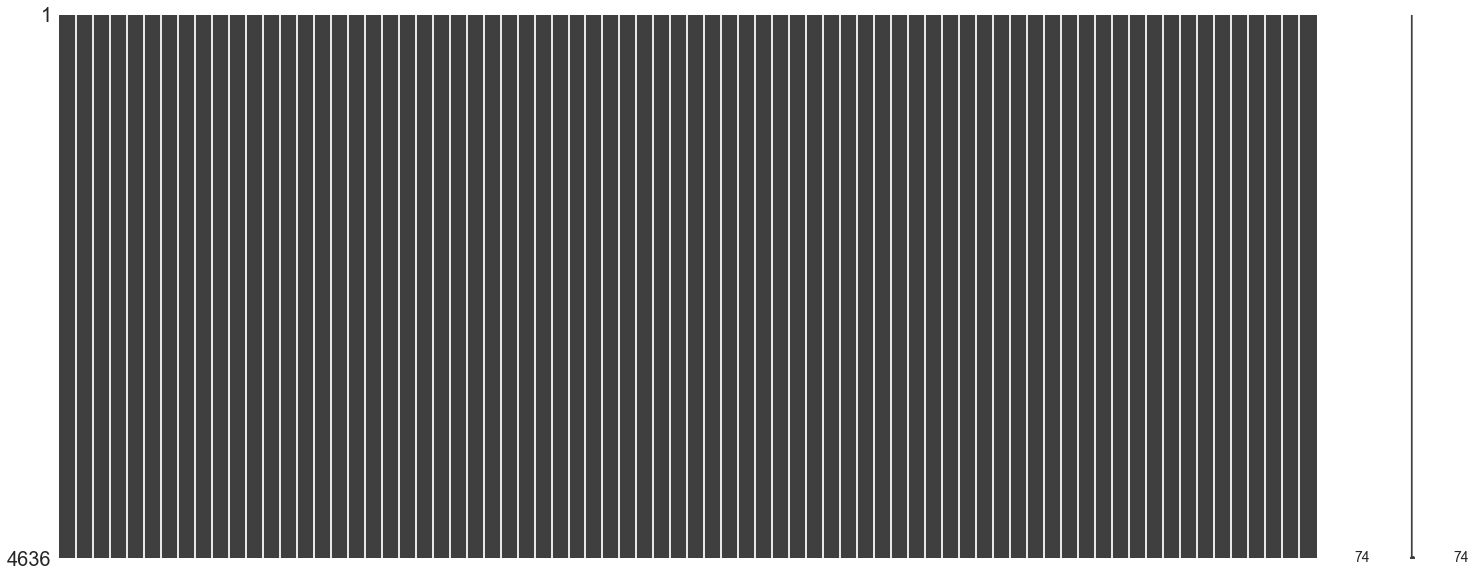

In [7]:
plt.figure(figsize=(4,4))
msngo.matrix(proc_df);

In [8]:
proc_df['arstmade'].value_counts('%')

N    0.939387
Y    0.060613
Name: arstmade, dtype: float64

In [9]:
proc_df.columns.values

array(['recstat', 'inout', 'trhsloc', 'typeofid', 'explnstp', 'othpers',
       'arstmade', 'sumissue', 'offunif', 'officrid', 'frisked',
       'searched', 'contrabn', 'pistol', 'riflshot', 'asltweap',
       'knifcuti', 'othrweap', 'pf_hands', 'pf_wall', 'pf_grnd',
       'pf_drwep', 'pf_ptwep', 'pf_baton', 'pf_hcuff', 'pf_pepsp',
       'pf_other', 'radio', 'ac_rept', 'ac_inves', 'rf_vcrim', 'rf_othsw',
       'ac_proxm', 'rf_attir', 'cs_objcs', 'cs_descr', 'cs_casng',
       'cs_lkout', 'rf_vcact', 'cs_cloth', 'cs_drgtr', 'ac_evasv',
       'ac_assoc', 'cs_furtv', 'rf_rfcmp', 'ac_cgdir', 'rf_verbl',
       'cs_vcrim', 'cs_bulge', 'cs_other', 'ac_incid', 'ac_time',
       'rf_knowl', 'ac_stsnd', 'ac_other', 'sb_hdobj', 'sb_outln',
       'sb_admis', 'sb_other', 'rf_furt', 'rf_bulg', 'offverb', 'offshld',
       'sex', 'race', 'haircolr', 'eyecolor', 'build', 'city', 'sector',
       'beat', 'post', 'month', 'meters'], dtype=object)

Las metricas han sido declaras en sus import, se utilizaran curvas roc, classification report y confussion matrix, entre otros

Para procesar la data utilizaremos labelencoder como primera estrategia debido a su gran poder de transformar la data.

Para separar las muestras trabajaremos con el 20% de test y el 80 de entrenamiento

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
lbl = LabelEncoder()
labels = ['recstat','sector','beat','post','inout','trhsloc','typeofid','explnstp','othpers','arstmade','sumissue','offunif','officrid','frisked','searched','contrabn','pistol','riflshot','asltweap','knifcuti','othrweap','pf_hands','pf_wall','pf_grnd','pf_drwep','pf_ptwep','pf_baton','pf_hcuff','pf_pepsp','pf_other','radio','ac_rept','ac_inves','rf_vcrim','rf_othsw','ac_proxm','rf_attir','cs_objcs','cs_descr','cs_casng','cs_lkout','rf_vcact','cs_cloth','cs_drgtr','ac_evasv','ac_assoc','cs_furtv','rf_rfcmp','ac_cgdir','rf_verbl','cs_vcrim','cs_bulge','cs_other','ac_incid','ac_time','rf_knowl','ac_stsnd','ac_other','sb_hdobj','sb_outln','sb_admis','sb_other','rf_furt','rf_bulg','offverb','offshld','sex','race','haircolr','eyecolor','build','city']
labStandar = ['inout', 'trhsloc', 'typeofid', 'explnstp', 'othpers', 'sumissue', 'offunif', 'officrid', 'frisked', 'searched', 'contrabn', 'pistol', 'riflshot', 'asltweap', 'knifcuti', 'othrweap', 'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep', 'pf_baton', 'pf_hcuff', 'pf_pepsp', 'pf_other', 'radio', 'ac_rept', 'ac_inves', 'rf_vcrim', 'rf_othsw', 'ac_proxm', 'rf_attir', 'cs_objcs', 'cs_descr', 'cs_casng', 'cs_lkout', 'rf_vcact', 'cs_cloth', 'cs_drgtr', 'ac_evasv', 'ac_assoc', 'cs_furtv', 'rf_rfcmp', 'ac_cgdir', 'rf_verbl', 'cs_vcrim', 'cs_bulge', 'cs_other', 'ac_incid', 'ac_time', 'rf_knowl', 'ac_stsnd', 'ac_other', 'sb_hdobj', 'sb_outln', 'sb_admis', 'sb_other', 'rf_furt', 'rf_bulg', 'offverb', 'offshld', 'sex', 'race', 'haircolr', 'eyecolor', 'build', 'month', 'meters']

In [12]:
proc_df.drop('arstmade',axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4636 entries, 0 to 5811
Data columns (total 73 columns):
recstat     4636 non-null object
inout       4636 non-null object
trhsloc     4636 non-null object
typeofid    4636 non-null object
explnstp    4636 non-null object
othpers     4636 non-null object
sumissue    4636 non-null object
offunif     4636 non-null object
officrid    4636 non-null object
frisked     4636 non-null object
searched    4636 non-null object
contrabn    4636 non-null object
pistol      4636 non-null object
riflshot    4636 non-null object
asltweap    4636 non-null object
knifcuti    4636 non-null object
othrweap    4636 non-null object
pf_hands    4636 non-null object
pf_wall     4636 non-null object
pf_grnd     4636 non-null object
pf_drwep    4636 non-null object
pf_ptwep    4636 non-null object
pf_baton    4636 non-null object
pf_hcuff    4636 non-null object
pf_pepsp    4636 non-null object
pf_other    4636 non-null object
radio       4636 non-null object
ac

In [13]:
for col in labels:
    proc_df[col] = lbl.fit_transform(proc_df[col])

In [14]:
X = proc_df.drop('arstmade',axis=1)
y = pd.DataFrame(proc_df.arstmade)

X_std = StandardScaler().fit_transform(X.loc[:,labStandar])

In [15]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=3367)

In [16]:
def roc_graphic(y_test, y_hat):
    from sklearn.metrics import roc_curve
    false_positive , true_positive , threshold = roc_curve(y_test,y_hat[:,1])
    plt.plot(false_positive,true_positive,lw = 1)
    plt.plot([0,1], linestyle='--', lw=1, color='tomato')
    plt.ylabel('Verdaderos Positivos')
    plt.xlabel('Falsos Positivos')

In [17]:
gs_naives = GridSearchCV(MultinomialNB(),
                         {'alpha':np.linspace(0.1,1.0,10), 
                          'fit_prior':[True,False], 
                          'class_prior':[None]},cv=5).fit(X_train,y_train)

In [18]:
pickle.dump(gs_naives, open('naives_bayes.sav','wb'))

In [19]:
gs_pred = gs_naives.predict(X_test)
gs_pred_proba = gs_naives.predict_proba(X_test)

In [20]:
print(classification_report(y_test, gs_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       876
           1       0.49      0.62      0.55        52

    accuracy                           0.94       928
   macro avg       0.73      0.79      0.76       928
weighted avg       0.95      0.94      0.95       928



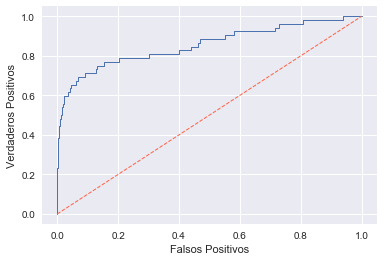

In [21]:
roc_graphic(y_test,gs_pred_proba)

In [22]:
dec_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),
                               {'min_samples_split': np.linspace(0.1,1.0,10),
                               'criterion':['gini','entropy'],
                               'max_depth': np.linspace(1,32,32),
                               'min_samples_leaf': np.linspace(0.1,0.5,10),
                               },cv=5).fit(X_train,y_train)

In [23]:
pickle.dump(dec_tree_grid_cv, open('decision_tree_model.sav','wb'))

In [24]:
dt_pred = dec_tree_grid_cv.predict(X_test)
dt_pred_proba = dec_tree_grid_cv.predict_proba(X_test)

In [25]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       876
           1       0.00      0.00      0.00        52

    accuracy                           0.94       928
   macro avg       0.47      0.50      0.49       928
weighted avg       0.89      0.94      0.92       928



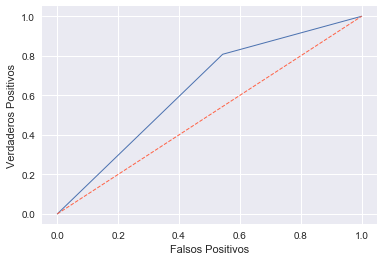

In [26]:
roc_graphic(y_test,dt_pred_proba)

In [27]:
rf_cv = GridSearchCV(RandomForestClassifier(),{
                                    'n_estimators': [4, 6, 9], 
                                    'max_features': ['log2', 'sqrt','auto'], 
                                    'criterion': ['entropy', 'gini'],
                                    'max_depth': [2, 3, 5, 10], 
                                    'min_samples_split': [2, 3, 5],
                                    'min_samples_leaf': [1,5,8]
                                     },cv=5).fit(X_train,y_train)

In [28]:
pickle.dump(rf_cv, open('random_forest.sav','wb'))

In [29]:
rf = rf_cv.predict(X_test)
rf_pred_proba = rf_cv.predict_proba(X_test)

In [30]:
print(classification_report(y_test, rf))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       876
           1       0.79      0.60      0.68        52

    accuracy                           0.97       928
   macro avg       0.89      0.79      0.83       928
weighted avg       0.97      0.97      0.97       928



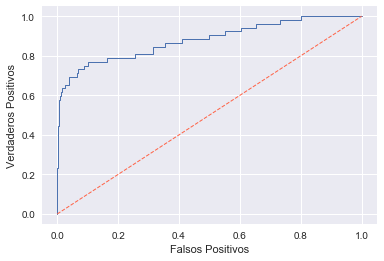

In [31]:
roc_graphic(y_test,rf_pred_proba)

In [32]:
ld_cv = GridSearchCV(LinearDiscriminantAnalysis(),{
                        'n_components':np.linspace(1,70,60,dtype=int), 
                        #'solver':['svd','lsqr','eigen'], 
                        }, cv=5).fit(X_train,y_train)

In [33]:
pickle.dump(ld_cv, open('linear_discriminant.sav','wb'))

In [34]:
ld = ld_cv.predict(X_test)
ld_pred_proba = ld_cv.predict_proba(X_test)

In [35]:
print(classification_report(y_test, ld))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       876
           1       0.78      0.62      0.69        52

    accuracy                           0.97       928
   macro avg       0.88      0.80      0.84       928
weighted avg       0.97      0.97      0.97       928



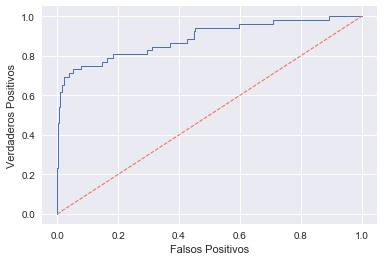

In [36]:
roc_graphic(y_test,ld_pred_proba)

In [37]:
c_param_range= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_param_range = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': c_param_range, 'gamma' : gamma_param_range}

In [38]:
svc_cv = GridSearchCV(SVC(kernel='rbf',probability=True),param_grid,cv = 10).fit(X_train,y_train)

In [39]:
pickle.dump(svc_cv, open('svc.sav','wb'))

In [40]:
svc = svc_cv.predict(X_test)
svc_pred_proba = svc_cv.predict_proba(X_test)

In [41]:
print(classification_report(y_test, svc))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       876
           1       0.86      0.62      0.72        52

    accuracy                           0.97       928
   macro avg       0.92      0.80      0.85       928
weighted avg       0.97      0.97      0.97       928



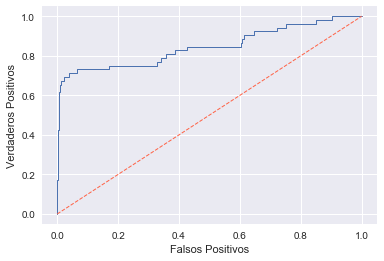

In [42]:
roc_graphic(y_test,svc_pred_proba)

Se adjuntan las grillas propuestas para los diversos modelos de evaluacion para el problema establecido, estas son para resolver problemas del tipo clasificacion

In [43]:
plt.rcParams['figure.figsize'] = (20,100)
def plot_importance(fit_model, feat_names):
    """TODO: Docstring for plot_importance.

    :fit_model: TODO
    :: TODO
    :returns: TODO

    """
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(len(feat_names)), tmp_importance[sort_importance])
    plt.yticks(range(len(feat_names)), names, rotation=0)
    return names

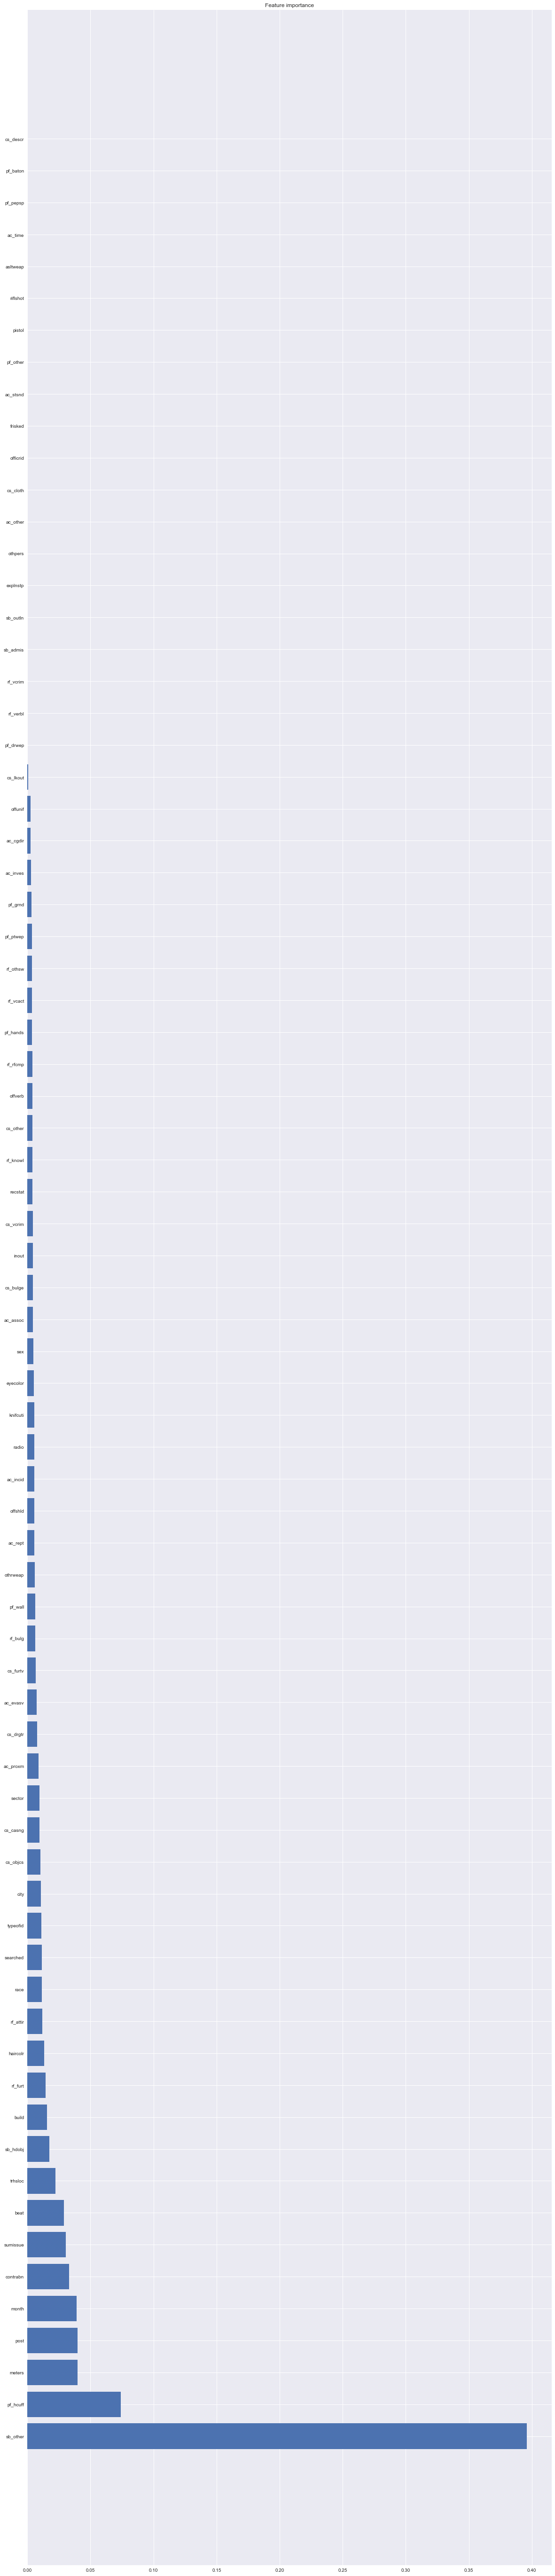

In [46]:
dec_tree = DecisionTreeClassifier().fit(X_train,y_train)
importance = plot_importance(dec_tree, X.columns)

In [50]:
importance[:30]

['sb_other',
 'pf_hcuff',
 'meters',
 'post',
 'month',
 'contrabn',
 'sumissue',
 'beat',
 'trhsloc',
 'sb_hdobj',
 'build',
 'rf_furt',
 'haircolr',
 'rf_attir',
 'race',
 'searched',
 'typeofid',
 'city',
 'cs_objcs',
 'cs_casng',
 'sector',
 'ac_proxm',
 'cs_drgtr',
 'ac_evasv',
 'cs_furtv',
 'rf_bulg',
 'pf_wall',
 'othrweap',
 'ac_rept',
 'offshld']

In [52]:
proc_df.columns

Index(['recstat', 'inout', 'trhsloc', 'typeofid', 'explnstp', 'othpers',
       'arstmade', 'sumissue', 'offunif', 'officrid', 'frisked', 'searched',
       'contrabn', 'pistol', 'riflshot', 'asltweap', 'knifcuti', 'othrweap',
       'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep', 'pf_baton',
       'pf_hcuff', 'pf_pepsp', 'pf_other', 'radio', 'ac_rept', 'ac_inves',
       'rf_vcrim', 'rf_othsw', 'ac_proxm', 'rf_attir', 'cs_objcs', 'cs_descr',
       'cs_casng', 'cs_lkout', 'rf_vcact', 'cs_cloth', 'cs_drgtr', 'ac_evasv',
       'ac_assoc', 'cs_furtv', 'rf_rfcmp', 'ac_cgdir', 'rf_verbl', 'cs_vcrim',
       'cs_bulge', 'cs_other', 'ac_incid', 'ac_time', 'rf_knowl', 'ac_stsnd',
       'ac_other', 'sb_hdobj', 'sb_outln', 'sb_admis', 'sb_other', 'rf_furt',
       'rf_bulg', 'offverb', 'offshld', 'sex', 'race', 'haircolr', 'eyecolor',
       'build', 'city', 'sector', 'beat', 'post', 'month', 'meters'],
      dtype='object')

In [60]:
X_30 = proc_df.loc[:,['sb_other','pf_hcuff','meters','post','month','contrabn','sumissue','beat','trhsloc','sb_hdobj','build','rf_furt','haircolr','rf_attir','race','searched','typeofid','city','cs_objcs','cs_casng','sector','ac_proxm','cs_drgtr','ac_evasv','cs_furtv','rf_bulg','pf_wall','othrweap','ac_rept','offshld']]
y_30 = pd.DataFrame(proc_df.arstmade)

X_std_30 = StandardScaler().fit_transform(X_30.loc[:,labStandar])

In [61]:
X_train_30 , X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=.20, random_state=3367)

In [68]:
gs_naives_30 = GridSearchCV(MultinomialNB(),
                         {'alpha':np.linspace(0.1,1.0,10), 
                          'fit_prior':[True,False], 
                          'class_prior':[None]},cv=5).fit(X_train_30,y_train_30)

In [71]:
gs_pred_30 = gs_naives_30.predict(X_test_30)
gs_pred_proba_30 = gs_naives_30.predict_proba(X_test_30)

In [72]:
print(classification_report(y_test, gs_pred_30))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       876
           1       0.52      0.63      0.57        52

    accuracy                           0.95       928
   macro avg       0.75      0.80      0.77       928
weighted avg       0.95      0.95      0.95       928



In [74]:
rf_cv_30 = GridSearchCV(RandomForestClassifier(),{
                                    'n_estimators': [4, 6, 9], 
                                    'max_features': ['log2', 'sqrt','auto'], 
                                    'criterion': ['entropy', 'gini'],
                                    'max_depth': [2, 3, 5, 10], 
                                    'min_samples_split': [2, 3, 5],
                                    'min_samples_leaf': [1,5,8]
                                     },cv=5).fit(X_train_30,y_train_30)

In [75]:
rf_30 = rf_cv_30.predict(X_test_30)
rf_pred_proba_30 = rf_cv_30.predict_proba(X_test_30)

In [76]:
print(classification_report(y_test_30, rf_30))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       876
           1       0.81      0.50      0.62        52

    accuracy                           0.97       928
   macro avg       0.89      0.75      0.80       928
weighted avg       0.96      0.97      0.96       928

